In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch import nn
import torch.nn.functional as F



#Sklearn
from sklearn.preprocessing import MinMaxScaler

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...


from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


# ML
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

manual_seed(444422)

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [5]:
#scaler = MinMaxScaler((0.3, np.pi-0.3))
#conjunto_train = scaler.fit_transform(conjunto_train)
#objetivo_train = (-1.6/(np.min(objetivo_train) - np.max(objetivo_train)))*objetivo_train - 0.8 + np.min(objetivo_train)*(1.6/(np.min(objetivo_train) - np.max(objetivo_train)))

In [6]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [7]:
train = ElecDataset(conjunto_train.reshape(conjunto_train.shape[0],conjunto_train.shape[1],1),objetivo_train)
test = ElecDataset(conjunto_test.reshape(conjunto_test.shape[0],conjunto_test.shape[1],1),objetivo_test)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)

In [8]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    feature_map = ZZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(n_qubits, reps=2)
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [9]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(2)

In [10]:
modelo_cuantico = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params, input_gradients=True
    )

In [11]:


class Net(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc1 = nn.Linear(12, 2)
        self.qnn = TorchConnector(modelo_cuantico)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc2 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.qnn(x)  # apply QNN
        x = self.fc2(x)
        return x




In [12]:
redHibrida = Net(modelo_cuantico).double()
optimizer = torch.optim.Adam(redHibrida.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [13]:
# Numero de parametros
total_params = sum(
	param.numel() for param in redHibrida.parameters()
)
total_params

34

In [14]:
redHibrida.train()
epochs = 200  # Set number of epochs
loss_list = []  # Store loss history

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = redHibrida(data)  # Forward pass
        #print("output ",output)
        #print("target ",target)
        loss = criterion(output, target)  # Calculate loss
        #print("loss ",loss)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        #print('--------------------------------------------------------------')
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training {}/{}\tLoss: {:.20f}".format((epoch + 1), epochs ,loss_list[-1]))

Training 1/200	Loss: 0.11755092709463561829
Training 2/200	Loss: 0.02467007530154172526
Training 3/200	Loss: 0.01159969561378621124
Training 4/200	Loss: 0.01107796116824996333
Training 5/200	Loss: 0.01101623111782135990
Training 6/200	Loss: 0.01102784660237873283
Training 7/200	Loss: 0.01095190037369523500
Training 8/200	Loss: 0.01065442177383986617
Training 9/200	Loss: 0.01022022683971104962
Training 10/200	Loss: 0.00983736815521977365
Training 11/200	Loss: 0.00959231181438733281
Training 12/200	Loss: 0.00945090475182792933
Training 13/200	Loss: 0.00939367548032359924
Training 14/200	Loss: 0.00935428297484007867
Training 15/200	Loss: 0.00933681657985868142
Training 16/200	Loss: 0.00932661881182579589
Training 17/200	Loss: 0.00931998140892794161
Training 18/200	Loss: 0.00931694269200654401
Training 19/200	Loss: 0.00931399771044179314
Training 20/200	Loss: 0.00931179507758107469
Training 21/200	Loss: 0.00931140075839877353
Training 22/200	Loss: 0.00930961929958976607
Training 23/200	Los

Training 182/200	Loss: 0.00308253703023346221
Training 183/200	Loss: 0.00305447916494605174
Training 184/200	Loss: 0.00306678814686049206
Training 185/200	Loss: 0.00298340611673006536
Training 186/200	Loss: 0.00300347710177488111
Training 187/200	Loss: 0.00294646213834514259
Training 188/200	Loss: 0.00292718682395221074
Training 189/200	Loss: 0.00296270615921836837
Training 190/200	Loss: 0.00296810045822987374
Training 191/200	Loss: 0.00268797639784473536
Training 192/200	Loss: 0.00236362296623237027
Training 193/200	Loss: 0.00224428710349821106
Training 194/200	Loss: 0.00218252729549703144
Training 195/200	Loss: 0.00214921346037978082
Training 196/200	Loss: 0.00214681946301963382
Training 197/200	Loss: 0.00212663289035444538
Training 198/200	Loss: 0.00210877226748799928
Training 199/200	Loss: 0.00209246277239239636
Training 200/200	Loss: 0.00207740745262480772


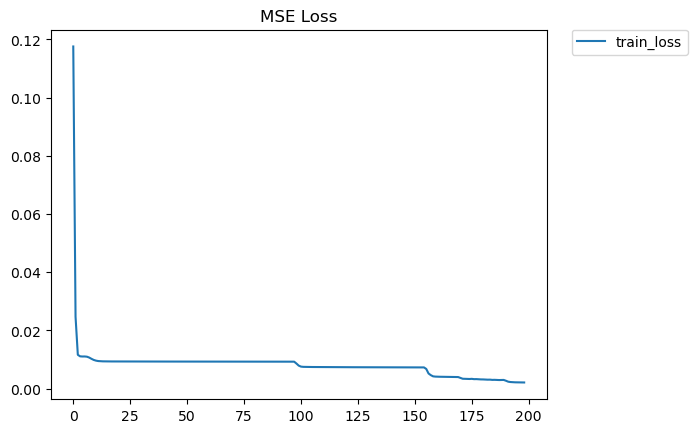

In [15]:
plt.plot(loss_list[:len(loss_list)-1],label='train_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [16]:
entrada = conjunto_train.reshape(conjunto_train.shape[0],conjunto_train.shape[1],1)

In [17]:
redHibrida.eval()
prediction = []
batch_size = 1
iterations =  int(entrada.shape[0]/batch_size)

for i in range(iterations):
    preds = redHibrida(torch.tensor(entrada[batch_size*i:batch_size*(i+1)]).double())
    prediction.append(preds[0].detach().numpy())
prediction = np.array(prediction)

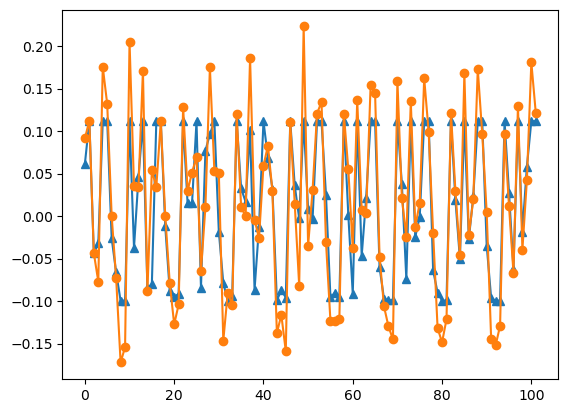

In [18]:
plt.plot(prediction, marker='^')
plt.plot(objetivo_train, marker='o')
plt.show()

In [19]:
np.sum( (prediction - objetivo_train)**2 )/len(objetivo_train)

0.0018802394992017265

In [20]:
entrada = conjunto_test.reshape(conjunto_test.shape[0],conjunto_test.shape[1],1)

In [21]:
prediction = []
batch_size = 1
iterations =  int(entrada.shape[0]/batch_size)

for i in range(iterations):
    preds = redHibrida(torch.tensor(entrada[batch_size*i:batch_size*(i+1)]).double())
    prediction.append(preds[0].detach().numpy())
prediction = np.array(prediction)

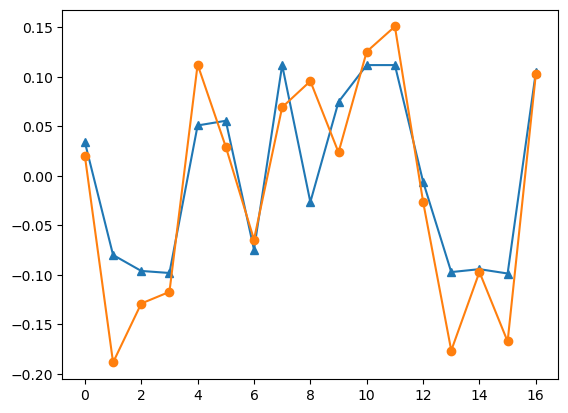

In [22]:
plt.plot(prediction, marker='^')
plt.plot(objetivo_test, marker='o')
plt.show()

In [23]:
error = 0

for i in range(len(prediction)):
    error = error + (prediction[i] - objetivo_test[i])**2
error/len(prediction)

0.002964244173276604